In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the elasticity summary
elasticity_summary = pd.read_csv('../data/elasticity_summary.csv')  

# Load average price and quantity per product
df = pd.read_csv('../data/sales_model_ready.csv')  

# Group by 'StockCode' and aggregate total revenue, total quantity, and mean quantity
grouped = df.groupby('StockCode').agg({
    'Revenue': 'sum',
    'Quantity': ['sum', 'mean']
}).reset_index()

# Flatten MultiIndex columns
grouped.columns = ['StockCode', 'Total_Revenue', 'Total_Quantity', 'Avg_Quantity']

# Calculate the average price as total revenue divided by total quantity
avg_price_qty = grouped[['StockCode']].copy()
avg_price_qty['UnitPrice'] = grouped['Total_Revenue'] / grouped['Total_Quantity']
avg_price_qty['Quantity'] = grouped['Avg_Quantity']
# Merge with elasticity
df_sim = pd.merge(avg_price_qty, elasticity_summary, on='StockCode', how='inner')

# Define a price range (80% to 120% of current price)
price_factors = np.linspace(0.8, 1.2, 21)

# Simulate revenue for each product
simulation_results = []

for _, row in df_sim.iterrows():
    stock_code = row['StockCode']
    p0 = row['UnitPrice']
    q0 = row['Quantity']
    e = row['Avg_Elasticity']
    
    for f in price_factors:
        new_price = p0 * f
        new_quantity = q0 * (f ** e)
        new_quantity = np.floor(new_quantity).astype(int) # Q_new = Q0 * (P_new / P0)^e
        revenue = new_price * new_quantity
        simulation_results.append({
            'StockCode': stock_code,
            'PriceFactor': f,
            'SimulatedPrice': new_price,
            'SimulatedQuantity': new_quantity,
            'SimulatedRevenue': revenue
        })

df_simulated = pd.DataFrame(simulation_results)


C:\Users\divya\AppData\Local\Temp\ipykernel_43876\2922178420.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/sales_model_ready.csv')


In [12]:
df_sim.head(10)

,StockCode,UnitPrice,Quantity,Avg_Elasticity
0,10125,0.712990,13.600000,-0.439535
1,10133,0.477436,16.283333,-1.055648
2,10135,0.934396,11.373913,-0.615022
3,11001,1.740955,11.017544,-1.472038
4,15036,0.812993,19.716312,-3.757955
5,15039,0.818811,8.274194,-4.205729
6,15044A,2.966608,4.500000,-2.043122
7,15044B,2.950000,4.200000,-5.928750
8,15044C,2.950000,3.700000,-5.992500
9,15044D,2.960143,4.179104,-4.752797


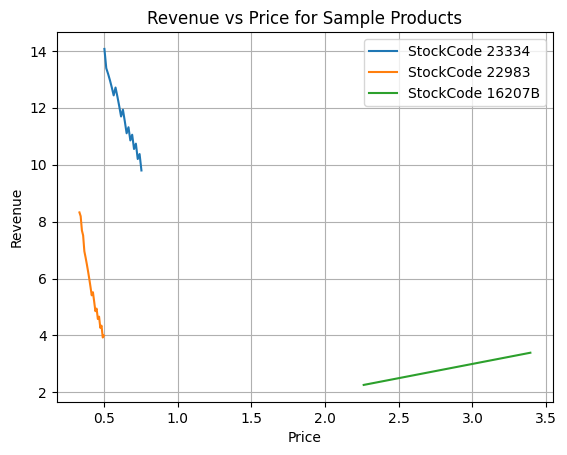

In [10]:
# Pick 3 random products to visualize
sample_codes = df_simulated['StockCode'].drop_duplicates().sample(3)

for code in sample_codes:
    df_plot = df_simulated[df_simulated['StockCode'] == code]
    plt.plot(df_plot['SimulatedPrice'], df_plot['SimulatedRevenue'], label=f'StockCode {code}')

plt.xlabel('Price')
plt.ylabel('Revenue')
plt.title('Revenue vs Price for Sample Products')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
df_simulated.to_csv('../data/price_simulation_results.csv', index=False)

Simulate Revenue at Different Price Points

Using the elasticity estimates, we simulated how revenue would change if each product’s price was increased or decreased in 5% steps from 80% to 120% of the current average.

- It lets us visualize the revenue curve for every product.
- Helps find the price point that maximizes revenue.
- Serves as the foundation for recommending prices in the next step.

We used the elasticity formula:

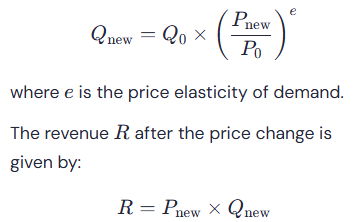
